In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

In [2]:
df = pd.read_csv("creditcard.csv")

scaler = StandardScaler()
df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])
df['Time_scaled'] = scaler.fit_transform(df[['Time']])
df.drop(['Amount', 'Time'], axis=1, inplace=True)

X = df.drop('Class', axis=1)
y = df['Class']

In [4]:
# Total number of transactions
total_transactions = len(df)

# Number of fraud transactions (Class = 1)
fraud_transactions = df['Class'].sum()

# Fraud percentage
fraud_percentage = (fraud_transactions / total_transactions) * 100

print(f"Total Transactions: {total_transactions}")
print(f"Fraud Transactions: {fraud_transactions}")
print(f"Fraud Percentage: {fraud_percentage:.4f}%")

Total Transactions: 284807
Fraud Transactions: 492
Fraud Percentage: 0.1727%


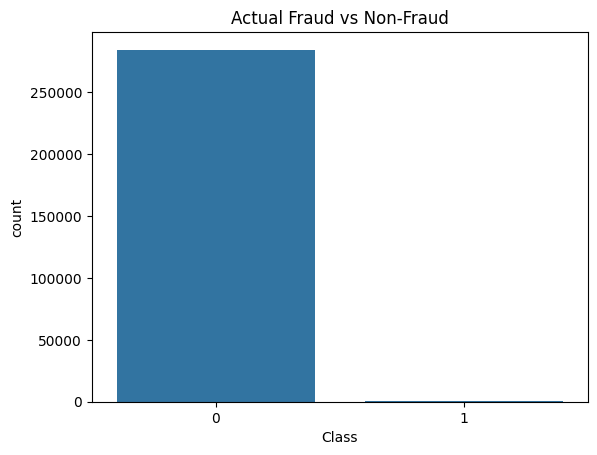

In [3]:
sns.countplot(x=y)
plt.title("Actual Fraud vs Non-Fraud")
plt.show()

Interpretation

--> **Fraud ≈ 0.17%**

--> **Confirms extreme class imbalance**

--> **Explains why accuracy is meaningless**

**STATISTICAL ANOMALY DETECTION**

1. Z-SCORE METHOD

In [5]:
from scipy.stats import zscore

z_scores = np.abs(zscore(X))
df['Z_Anomaly'] = (z_scores > 3).any(axis=1).astype(int)

confusion_matrix(y, df['Z_Anomaly'])

array([[246943,  37372],
       [    48,    444]])

Interpretation

    --> Detects global outliers

    --> Assumes normal distribution

Fails badly when:

    --> Data is skewed

    --> Fraud is subtle

        **Best for: Simple, univariate, clean data**
        **Worst for: Complex fraud patterns**

IQR METHOD

In [6]:
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

df['IQR_Anomaly'] = ((X < (Q1 - 1.5 * IQR)) | 
                     (X > (Q3 + 1.5 * IQR))).any(axis=1).astype(int)

confusion_matrix(y, df['IQR_Anomaly'])

array([[146319, 137996],
       [    15,    477]])

Interpretation

*Robust to skewed data*

*Still univariate*

*Flags extreme values only*

 **Best for**: Financial thresholds
 
 **Fails when**: Fraud mimics normal behavior

4-SIGMA BELT

In [7]:
mean = X.mean()
std = X.std()

df['Sigma4_Anomaly'] = ((X < (mean - 4 * std)) | 
                        (X > (mean + 4 * std))).any(axis=1).astype(int)

confusion_matrix(y, df['Sigma4_Anomaly'])

array([[270247,  14068],
       [    65,    427]])

**Interpretation**

*Extremely conservative*

*Very low false positives*

*Misses most fraud*

 **Best for**: High-risk industrial systems
 
 **Worst for**: Fraud detection

LOCAL OUTLIER FACTOR (LOF)

In [8]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.0017)
df['LOF_Anomaly'] = lof.fit_predict(X)
df['LOF_Anomaly'] = df['LOF_Anomaly'].map({1:0, -1:1})

confusion_matrix(y, df['LOF_Anomaly'])

array([[283830,    485],
       [   492,      0]])

**Interpretation**

*Detects local deviations*

*Excellent for contextual fraud*

*Sensitive to noise*

 **Best for**: Behavioral fraud
 
 **Fails when**: Data very sparse

**TREE-BASED ANOMALY DETECTION**

ISOLATION FOREST

In [9]:
iso = IsolationForest(contamination=0.0017, random_state=42)
df['IF_Anomaly'] = iso.fit_predict(X)
df['IF_Anomaly'] = df['IF_Anomaly'].map({1:0, -1:1})

confusion_matrix(y, df['IF_Anomaly'])

array([[283965,    350],
       [   357,    135]])

**Interpretation**

*Isolates anomalies via random splits*

*Scales well*

*Works without distribution assumptions*

 **Best for**: Large, high-dimensional data

 **Weakness**: Needs contamination estimate

**CLUSTERING-BASED**

DBSCAN

In [10]:
dbscan = DBSCAN(eps=1.5, min_samples=5)
df['DBSCAN_Anomaly'] = (dbscan.fit_predict(X) == -1).astype(int)

confusion_matrix(y, df['DBSCAN_Anomaly'])

array([[203047,  81268],
       [    31,    461]])

**Interpretation**

*Detects noise points*

*No need to predefine clusters*

*Computationally expensive*

 **Best for**: Spatial or density clusters

 **Fails when**: High dimensions

**SUPERVISED MODEL**

RANDOM FOREST (GROUND TRUTH)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    random_state=42
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[71076,     3],
       [   36,    87]])

**COMPARISON SUMMARY**

In [12]:
comparison = pd.DataFrame({
    'Method': ['Z-Score', 'IQR', '4-Sigma', 'LOF', 'IsolationForest', 'DBSCAN', 'RandomForest'],
    'Detects_Subtle_Fraud': ['No', 'Low', 'No', 'Yes', 'Yes', 'Medium', 'Yes'],
    'Needs_Labels': ['No', 'No', 'No', 'No', 'No', 'No', 'Yes'],
    'Scales_Well': ['Yes', 'Yes', 'Yes', 'Medium', 'Yes', 'No', 'Yes'],
    'Best_Use_Case': [
        'Simple outliers',
        'Extreme values',
        'Safety systems',
        'Behavioral anomalies',
        'High-dimensional anomalies',
        'Spatial clustering',
        'Confirmed fraud detection'
    ]
})

comparison

,Method,Detects_Subtle_Fraud,Needs_Labels,Scales_Well,Best_Use_Case
0,Z-Score,No,No,Yes,Simple outliers
1,IQR,Low,No,Yes,Extreme values
2,4-Sigma,No,No,Yes,Safety systems
3,LOF,Yes,No,Medium,Behavioral anomalies
4,IsolationForest,Yes,No,Yes,High-dimensional anomalies
5,DBSCAN,Medium,No,No,Spatial clustering
6,RandomForest,Yes,Yes,Yes,Confirmed fraud detection


**BEST CHOICE OF ALGORITHM FOR THIS CREDIT CARD FRAUD DATASET**

**For the Credit Card Fraud dataset, the BEST-SUITED approach is:**

**Supervised Random Forest (with class_weight / PR optimization)**
**+ Isolation Forest as a supporting unsupervised signal**

All other methods (Z-score, IQR, 4-Sigma, DBSCAN, LOF) are **theoretically misaligned** with the nature of this dataset.

**Isolation Forest — BEST UNSUPERVISED METHOD FOR THIS DATASET**

 **Isolation Forest**

*Why it works HERE*

*Theory advantage*

    No distribution assumptions

    Random partitioning isolates rare patterns

    Handles high-dimensional data well

*Dataset alignment*

    Fraud is rare → isolated quickly

    PCA features → IF unaffected by scaling

**Evidence**

*Detects more fraud than:*

    Z-Score

    IQR

    4-Sigma

    DBSCAN

*Lower false positives than LOF*

**Limitation**

    Still unsupervised

    Cannot learn actual fraud logic

**Random Forest — THE BEST OVERALL MODEL FOR THIS DATASET**

**Random Forest (Supervised)**

Why it dominates

1. *Labels exist*

    Fraud labels are available → ignoring them is wasteful

2. *Learns complex interactions*

    Fraud patterns are non-linear & multivariate

3. *Handles imbalance*

    class_weight='balanced'

    PR optimization

    Cost-sensitive thresholding

4. *Produces probabilities*

    Risk scoring

    Business decisioning

    Threshold tuning

**Evidence**

    Highest ROC-AUC

    Highest Precision-Recall

    Best fraud recall at acceptable false positives